### Test Rasterizer

In [60]:
from glob import glob

import torch
from scene import Scene
import os
import sys
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from argparse import ArgumentParser, Namespace

from utils.general_utils import safe_state
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel

# Set up command line argument parser
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")

args_cmdline = parser.parse_args(args=[
    "--model_path",
    "/home/hjp/KUAICV/NIPS2024_LOCAL/gaussian-splatting/output/58aa8b75-e/",
    
    "--source_path",
    "/home/hjp/KUAICV/NIPS2024_LOCAL/datasets/tandt/train/"
])

cfgfile_string = "Namespace()"
try:
    cfgfilepath = os.path.join(args_cmdline.model_path, "cfg_args")
    print("Looking for config file in", cfgfilepath)
    with open(cfgfilepath) as cfg_file:
        print("Config file found: {}".format(cfgfilepath))
        cfgfile_string = cfg_file.read()
except TypeError:
    print("Config file not found at")
    pass
print("Config file arguments: ", cfgfile_string)

args_cfgfile = eval(cfgfile_string)

merged_dict = vars(args_cfgfile).copy()
for k,v in vars(args_cmdline).items():
    if v != None:
        merged_dict[k] = v
args = Namespace(**merged_dict)

assert os.path.exists(args.model_path), "Model path does not exist"
assert os.path.exists(args.source_path), "Source path does not exist"

model_args = model.extract(args)
pipe_args = pipeline.extract(args)

print(model_args.resolution)


Looking for config file in /home/hjp/KUAICV/NIPS2024_LOCAL/gaussian-splatting/output/58aa8b75-e/cfg_args
Config file found: /home/hjp/KUAICV/NIPS2024_LOCAL/gaussian-splatting/output/58aa8b75-e/cfg_args
Config file arguments:  Namespace(data_device='cuda', eval=False, images='images', model_path='./output/58aa8b75-e', resolution=-1, sh_degree=3, source_path='/home/hjp/KUAICV/NIPS2024_LOCAL/datasets/tandt/train', white_background=False)
-1


In [90]:
_ =  """
from scene.dataset_readers import sceneLoadTypeCallbacks
from utils.camera_utils import cameraList_from_camInfos, camera_to_JSON
from utils.general_utils import PILtoTorch


scene_info = sceneLoadTypeCallbacks["Colmap"](
    model_args.source_path,
    model_args.images,
    model_args.eval
)

train_cameras = cameraList_from_camInfos(scene_info.train_cameras, 1.0, model_args)
"""

In [89]:
_ = """
from utils.general_utils import PILtoTorch
from scene.cameras import Camera

cam_info = scene_info.train_cameras[0]

resized_image_rgb = PILtoTorch(
    scene_info.train_cameras[0].image, scene_info.train_cameras[0].image.size
)

Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)
"""

In [54]:
gaussians = GaussianModel(model_args.sh_degree)
scene = Scene(
    model_args, gaussians, 
    load_iteration = args.iteration, shuffle = False
)

Loading trained model at iteration 60000
Reading camera 301/301
Loading Training Cameras
Loading Test Cameras


In [91]:
bg_color = [1,1,1] if model_args.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

camera = scene.getTrainCameras()[0]

render_pkg = render(
    camera, gaussians, pipe_args, background
)

In [142]:
camera.image_name

'00001'

In [158]:
for idx, camera in enumerate(scene.getTrainCameras()) :
    render_pkg = render(
        camera, gaussians, pipe_args, background
    )
    print(
        camera.image_name,
        render_pkg["viewspace_points"].shape,
        render_pkg["viewspace_points"].sum().item(),
        (render_pkg["radii"][render_pkg["visibility_filter"]] == 0).sum().item(),
        (render_pkg["radii"][~render_pkg["visibility_filter"]] != 0).sum().item()   
    )

00001 torch.Size([1070179, 3]) 0.0 0 0
00002 torch.Size([1070179, 3]) 0.0 0 0
00003 torch.Size([1070179, 3]) 0.0 0 0
00004 torch.Size([1070179, 3]) 0.0 0 0
00005 torch.Size([1070179, 3]) 0.0 0 0
00006 torch.Size([1070179, 3]) 0.0 0 0
00007 torch.Size([1070179, 3]) 0.0 0 0
00008 torch.Size([1070179, 3]) 0.0 0 0
00009 torch.Size([1070179, 3]) 0.0 0 0
00010 torch.Size([1070179, 3]) 0.0 0 0
00011 torch.Size([1070179, 3]) 0.0 0 0
00012 torch.Size([1070179, 3]) 0.0 0 0
00013 torch.Size([1070179, 3]) 0.0 0 0
00014 torch.Size([1070179, 3]) 0.0 0 0
00015 torch.Size([1070179, 3]) 0.0 0 0
00016 torch.Size([1070179, 3]) 0.0 0 0
00017 torch.Size([1070179, 3]) 0.0 0 0
00018 torch.Size([1070179, 3]) 0.0 0 0
00019 torch.Size([1070179, 3]) 0.0 0 0
00020 torch.Size([1070179, 3]) 0.0 0 0
00021 torch.Size([1070179, 3]) 0.0 0 0
00022 torch.Size([1070179, 3]) 0.0 0 0
00023 torch.Size([1070179, 3]) 0.0 0 0
00024 torch.Size([1070179, 3]) 0.0 0 0
00025 torch.Size([1070179, 3]) 0.0 0 0
00026 torch.Size([1070179

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


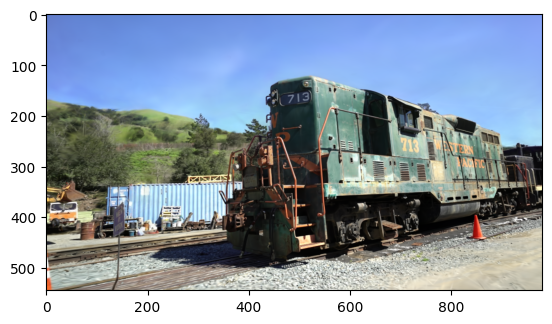

In [169]:
import matplotlib.pyplot as plt

plt.imshow(
    render_pkg["render"].detach().cpu().numpy().transpose(1,2,0)
)

In [ ]:
# visualize 3D position of camera by extrinsic matrix


In [170]:
train_camera_list = scene.getTrainCameras()

In [172]:
train_camera_list[0].T


array([0.83072447, 0.42330418, 4.72019668])